In [1]:
from read_write import read
from stats import percentage, absolute
from viz import heatmap, bar
from utils import time_op, shape, string_op, probability
import numpy as np
from datetime import datetime
import dateutil
import pandas as pd

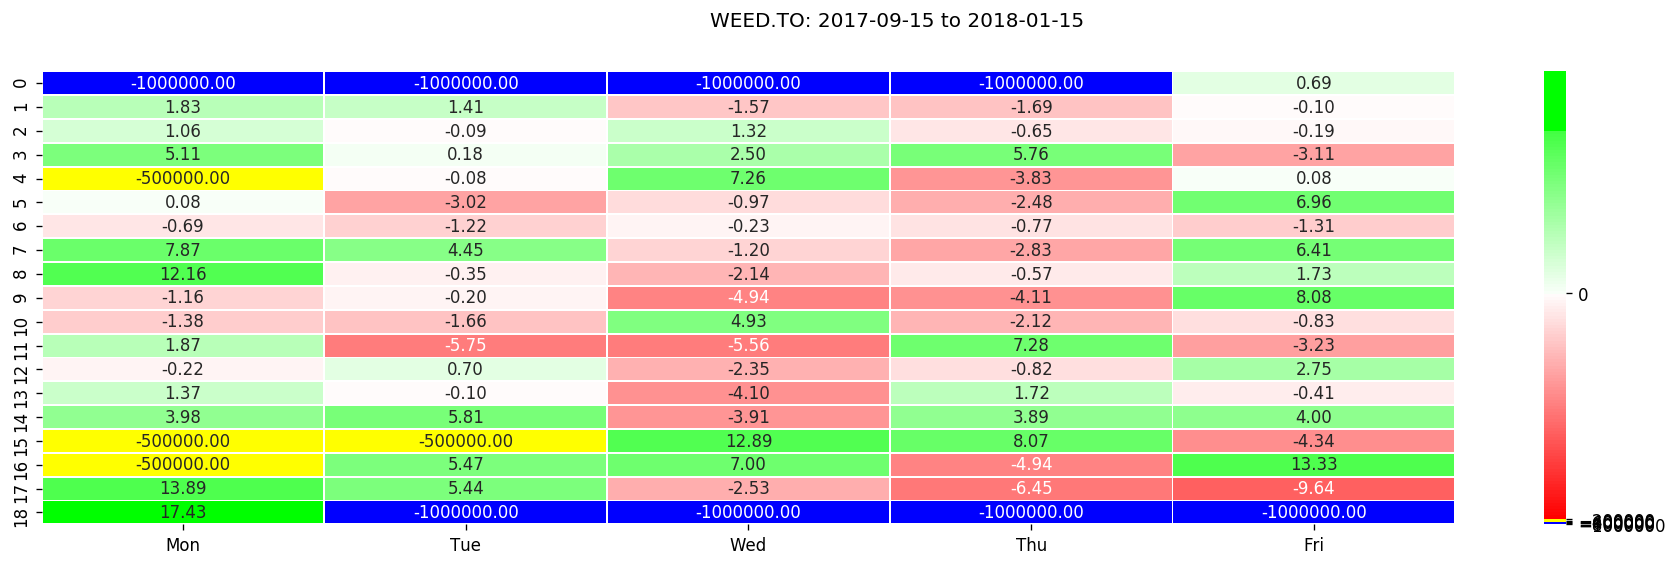

In [5]:
#symbol = "LEAF.TO"
#symbol = "APH.TO"
symbol = "WEED.TO"
#symbol = "NVDA"

end_date = datetime.today() #today
start_date = end_date + dateutil.relativedelta.relativedelta(months=-4) #month ago

date, num_data = read.get_data_from_web(symbol, start_date, end_date)

sh = np.shape(date)

days = []
for i in range (sh[0]):
#    day = time.get_day_number_from_date_string(date[i][0])
    day = time_op.get_day_number_from_date_string(date[i].strftime("%Y-%m-%d"))
    days.append(day)

#nd = read.get_numeric_data_from_all_data(data)
pc = percentage.get_percentage_change_from_numeric_data(num_data)
perc = pc * 100

range_pc = percentage.get_high_low_percentage_change_from_numeric_data(num_data)
range_perc = range_pc * 100

mod = 5

shaped_perc = shape.reshape_data(perc, days, mod)
shaped_range = shape.reshape_data(range_perc, days, mod)

title = symbol + ": " + start_date.strftime("%Y-%m-%d")+ " to " + end_date.strftime("%Y-%m-%d")

heatmap.show(shaped_perc, title, mod)


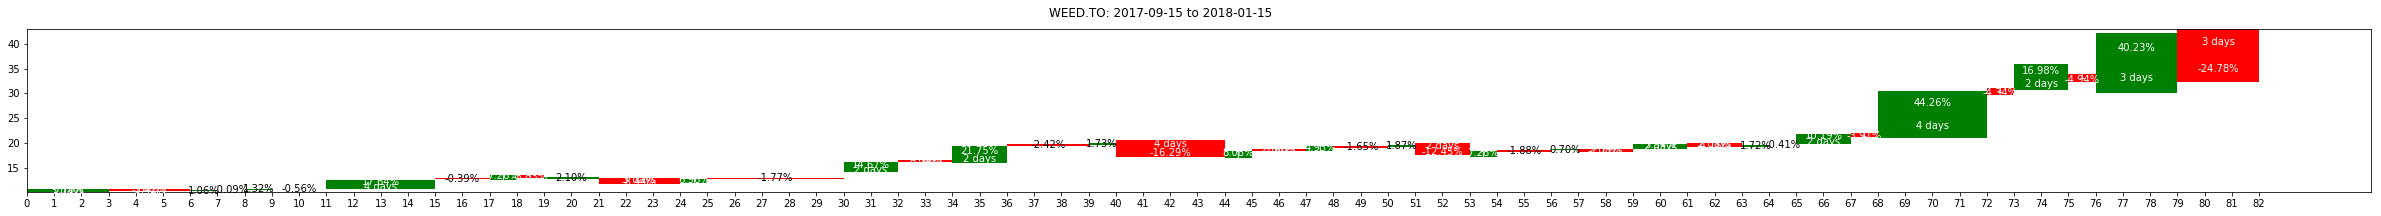

In [3]:
change = absolute.get_absolute_change_from_numeric_data(num_data)

#print change

sh = np.shape(change)

POSITIVE_TYPE = 1
NEGATIVE_TYPE = -1
current_type = 0 

#consec_pos_day_gain = []
#consec_neg_day_loss = []
consec_day = []

pos_start = 0
pos_end = 0

neg_start = 0
neg_end = 0

count = 0


for i in range (sh[0]):
    #if positive day
    if (change[i][0] > 0):
        if current_type == POSITIVE_TYPE:
            count = count + 1
            continue
        elif current_type == NEGATIVE_TYPE:
            neg_end = read.get_closing_price_from_numeric_data(num_data[i-1:i])[0][0]
            record = np.array([neg_start, neg_end, count])
            consec_day.append(record)
 
            pos_start = read.get_opening_price_from_numeric_data(num_data[i:i+1])[0][0]
            count = 1
        else:
            pos_start = read.get_opening_price_from_numeric_data(num_data[i:i+1])[0][0]
            count = 1
        current_type = POSITIVE_TYPE
    else:
        if current_type == NEGATIVE_TYPE:
            count = count + 1
            continue
        elif current_type == POSITIVE_TYPE:
            pos_end = read.get_closing_price_from_numeric_data(num_data[i-1:i])[0][0]
            record = np.array([pos_start, pos_end, count])
            consec_day.append(record)

            neg_start = read.get_opening_price_from_numeric_data(num_data[i:i+1])[0][0]
            count = 1
        else:
            neg_start = read.get_opening_price_from_numeric_data(num_data[i:i+1])[0][0]
            count = 1
        current_type = NEGATIVE_TYPE


#append last end
if current_type == POSITIVE_TYPE:
    pos_end = read.get_closing_price_from_numeric_data(num_data[i:i+1])[0][0]
    record = np.array([pos_start, pos_end, count])
    consec_day.append(record)
else:
    neg_end = read.get_closing_price_from_numeric_data(num_data[i:i+1])[0][0]
    record = np.array([neg_start, neg_end, count])
    consec_day.append(record)

np_consec_day = np.array(consec_day)

bar.show(np_consec_day, title)


In [4]:
data = np.zeros(shape=(4, mod))

for i in range (mod):
    data[0, i] = probability.get_positive_probability_of_day(shaped_perc[:,i])
    data[1, i], data[2, i] = absolute.get_mean_and_deviation_of_day(shaped_perc[:,i])
    data[3, i], _ = absolute.get_mean_and_deviation_of_day(shaped_range[:,i])

df = pd.DataFrame(data, columns=['Mon','Tue', 'Wed', 'Thu', 'Fri'], index=['Probability of positive','Mean','Deviation','Mean Range'])
print df


                              Mon       Tue       Wed       Thu       Fri
Probability of positive  0.714286  0.437500  0.352941  0.294118  0.500000
Mean                     3.268342  0.686406  0.377102 -0.266414  1.160583
Deviation                4.694998  3.109979  4.890472  4.123908  5.109183
Mean Range               6.948390  8.105998  7.756909  5.902921  6.016326
